# Library

In [ ]:
import warnings

warnings.filterwarnings("ignore", message="Boolean Series key will be reindexed to match DataFrame index")
warnings.filterwarnings("ignore", category=FutureWarning, module="pyntcloud.io.ply")
warnings.filterwarnings("ignore", category=RuntimeWarning)

import os
import time
import itertools
import shutil
import subprocess

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull
from pyntcloud import PyntCloud

from vggsfm.datasets.imc_helper import (
    read_cameras_binary, write_cameras_text,
    read_images_binary, write_images_text,
    read_points3D_binary, write_points3D_text
    )

from Utilities.utilities import (
    read_points3D, 
    write_ply, 
    calculate_volume, 
    calculate_volume_file
    )

# Calculate Volume

In [2]:
def get_folders_in_directory(directory):
    # Get a list of all files and folders in the specified directory
    items = os.listdir(directory)
    # Filter out the items that are folders
    folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    return folders

def list_directory_contents(directory):
    # Get a list of all files and folders in the specified directory
    items = os.listdir(directory)
    return items

def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Get the list of folders in the directory
# directory_path = f'/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_50_3'
directory_path = f'/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_input/image_input_100_5'
folders = get_folders_in_directory(directory_path)
folders.sort()

# print(folders)

##################################################
# List Algorithm
##################################################
list_algorithm = [
    'MVG',
    'MVG_MVS',
    # 'COLMAP',
    # 'COLMAP_MVS',
    # 'VGGSFM', # Use Python 3.12.7
    # 'MVE',
]

##################################################
# Run No Background
##################################################
list_bg = [
    'with_bg', 
    # 'no_bg',
    ]

##################################################
# Scale and Frame
##################################################
# list_scale_percent = [100, 50]
# list_scale_percent = [50]
# list_scale_percent = [50]
# list_max_frames = [30, 45, 60, 75, 90, 105]
list_scale_percent = [100]
list_max_frames = [5]


# list_subject_testing = ['8', '9', '17', '19', '22', '67']
# list_subject_testing = [1, 2, 6, 7, 8, 9, 
#                         10, 11, 12, 16, 17, 18, 19, 
#                         21, 22, 23, 24, 27, 29, 
#                         30, 35, 
#                         41, 45, 46, 49, 
#                         51, 55, 56, 59, 
#                         60, 61, 63, 67, 69]
# list_subject_testing = [str(x) for x in list_subject_testing]

##################################################
# Run
##################################################
results_volume = []


for scale_percent, max_frames in itertools.product(list_scale_percent, list_max_frames):
    for (algorithm, bg) in itertools.product(list_algorithm, list_bg):
        # folders = ['2']
        for folder in folders:
            folder_path = os.path.join(directory_path, folder)
            
            # Get the list of files and folders in the directory
            contents = list_directory_contents(folder_path)
            contents = [x for x in contents if ':Zone.Identifier' not in x]
            subject = folder_path.split('/')[-1].split('.')[0]

            # if subject in list_subject_testing:
            if True:

                for data in contents:         
                    print('')       
                    print(f'Subject {subject} - {data} - {bg} - {algorithm} - Scale: {scale_percent}, Max Frames: {max_frames}')
                    
                    # If no bg
                    if bg == 'with_bg':
                        path_bg = ''
                    else:
                        path_bg = '_no_bg'
                        
                    start_time = time.time()
                    error = ''
                    
                    path_base = f'/home/weiyanpeh/Git/SFM_Related/CADENCE'

                    if "COLMAP" in algorithm:
                        path_volume = f"{path_base}/SHAPE_Frames_output/colmap_mvs_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/sfm/dense/sparse"
                        points3D = read_points3D_binary(path_volume + "/points3D.bin")

                        write_points3D_text(points3D, path_volume + "/points3D.txt")

                        points3D_file = path_volume + "/points3D.txt"
                        output_ply_file = path_volume + "/cloud_and_poses.ply"
                        
                        points3D = read_points3D(points3D_file)
                        write_ply(points3D, output_ply_file)

                        print(f'PLY file saved to {output_ply_file}')


                    dict_algorithm_path = {
                        'MVG': {
                            'file_path': f"{path_base}/SHAPE_Frames_output/mvg_mvs_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/sfm", 
                            'file_name': ["cloud_and_poses.ply"]},
                        
                        'MVG_MVS': {
                            'file_path': f"{path_base}/SHAPE_Frames_output/mvg_mvs_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/mvs", 
                            'file_name': ["scene_dense_mesh.ply", "scene_dense_texture.ply", "scene_dense_mesh_refine.ply"]},
                            # "scene_dense.ply" always get error "field 'n_coords' occurs more than once"
                        
                        'COLMAP_MVS': {
                            'file_path': f"{path_base}/SHAPE_Frames_output/colmap_mvs_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/mvs", 
                            'file_name': ["scene_dense_mesh.ply", "scene_dense_texture.ply", "scene_dense_mesh_refine.ply"]},
                            # "scene_dense.ply" always get error "field 'n_coords' occurs more than once"

                        # OpenMVS Colamp
                        'COLMAP': {
                            'file_path': f"{path_base}/SHAPE_Frames_output/colmap_mvs_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/sfm/dense/sparse", 
                            'file_name': ["cloud_and_poses.ply"]},
                        
                        # 'MVG': {
                        #     'file_path': f"{path_base}/SHAPE_Frames_output/mvg/{subject}/{data}/reconstruction_sequential",
                        #     'file_name': ["cloud_and_poses.ply"]},
                        
                        # Real COLMAP
                        # 'COLMAP': {
                            # 'file_path': f"{path_base}/SHAPE_Frames_input/images_input_colmap_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/dense", 
                            # 'file_name': ["fused.ply", "meshed-poisson.ply", "meshed-delaunay.ply"]},
                        
                        'VGGSFM': {
                            'file_path': f"{path_base}/SHAPE_Frames_input/images_input_vggsfm_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/sparse", 
                            'file_name': ["output.ply"]},

                        'MVE': {
                            'file_path': f"{path_base}/SHAPE_Frames_input/images_input_mve_{scale_percent}_{max_frames}{path_bg}/{subject}/{data}/convert", 
                            'file_name': ["pset-L2.ply", "surface-L2.ply", "surface-L2-clean.ply"]},

                    }

                    file_path = dict_algorithm_path[algorithm]['file_path']
                    list_file_name = dict_algorithm_path[algorithm]['file_name']
                    sfm_model = ''
                    
                    if algorithm in ['MVG', 'MVG_MVS']:
                        sfm_model = 'MVG_MVS'
                    elif algorithm in ['COLMAP', 'COLMAP_MVS']:
                        sfm_model = 'COLMAP_MVS'
                    else:
                        sfm_model = algorithm

                    for file_name in list_file_name:
                        error = ''
                        try:
                            start_time = time.time()  # Record the start time

                            print(file_path)
                            print(file_name)

                            volume = calculate_volume_file(
                                file_path = file_path, 
                                file_name = file_name
                                )
                            
                            print(f'{file_name} - Volume: {round(volume, 3)} unit3')
                            
                            end_time = time.time()  # Record the end time
                            execution_time = end_time - start_time  # Calculate the execution 
                            
                            results_volume.append([
                                subject, data, sfm_model,
                                algorithm, bg, scale_percent, max_frames,
                                execution_time, 'PyntCloud', file_path, file_name, 
                                volume, error])
                            
                        except Exception as error:
                            print(file_name, error)
                            end_time = time.time()  # Record the end time
                            execution_time = end_time - start_time  # Calculate the execution 
                            results_volume.append([
                                subject, data, sfm_model,
                                algorithm, bg, scale_percent, max_frames, 
                                execution_time, 'PyntCloud', file_path, file_name, 
                                0, error])

# Convert to DataFrame
columns = ['Subject', 'Image Data', 'SFM',
           'Algorithm', 'BG', 'Scale', 'Max Frames', 
           'Execution_time', 'Volume Calculation', 'File_Path', 'File_Name', 
           'Volume', 'Error']
df_results = pd.DataFrame(results_volume, columns=columns)
df_results = df_results.drop('Execution_time', axis=1)
df_results.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_volume.csv', index=False)
    



Subject 1 - 1D0L - with_bg - MVG - Scale: 100, Max Frames: 5
/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_output/mvg_mvs_100_5/1/1D0L/sfm
cloud_and_poses.ply
cloud_and_poses.ply - Volume: 49.663 unit3

Subject 1 - 1D0R - with_bg - MVG - Scale: 100, Max Frames: 5
/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_output/mvg_mvs_100_5/1/1D0R/sfm
cloud_and_poses.ply
cloud_and_poses.ply - Volume: 6.054 unit3

Subject 10 - 10D2R - with_bg - MVG - Scale: 100, Max Frames: 5
/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_output/mvg_mvs_100_5/10/10D2R/sfm
cloud_and_poses.ply
cloud_and_poses.ply - Volume: 3348.356 unit3

Subject 10 - 10D2L - with_bg - MVG - Scale: 100, Max Frames: 5
/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_output/mvg_mvs_100_5/10/10D2L/sfm
cloud_and_poses.ply
cloud_and_poses.ply [Errno 2] No such file or directory: '/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_Frames_output/mvg_mvs_100_5/10/10D2L/sfm/cloud_and_poses.ply'

Subject 10 - 10D0R - with_b

In [3]:
subject_sorted = list(set(df_results['Subject'].tolist()))
subject_sorted.sort()
subject_sorted

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '8',
 '9']

In [4]:
df_results

,Subject,Image Data,SFM,Algorithm,BG,Scale,Max Frames,Volume Calculation,File_Path,File_Name,Volume,Error
0,1,1D0L,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,49.662720,
1,1,1D0R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,6.053574,
2,10,10D2R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,3348.356004,
3,10,10D2L,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,0.000000,[Errno 2] No such file or directory: '/home/we...
4,10,10D0R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,448.705590,
...,...,...,...,...,...,...,...,...,...,...,...,...
1707,9,9D1R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_texture.ply,134.319408,
1708,9,9D1R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_mesh_refine.ply,134.319721,
1709,9,9D3R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_mesh.ply,0.000000,[Errno 2] No such file or directory: '/home/we...
1710,9,9D3R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_texture.ply,0.000000,[Errno 2] No such file or directory: '/home/we...


In [5]:
df_results_grouped = df_results.copy()

df_results_grouped = df_results_grouped[df_results_grouped['Volume'] != 0].reset_index(drop=True)
df_results_grouped = df_results_grouped.drop(['BG', 'Scale', 'Max Frames'], axis=1)

# Group by Subject, Image Data, and Algorithm
df_results_grouped = df_results_grouped.groupby(['Subject', 'Image Data', 'Algorithm', 'File_Name']).sum()

# Check if Volume is non-zero
df_results_grouped['!0'] = df_results_grouped['Volume'] != 0
df_results_grouped.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_2_volume_grouped.csv')

print(df_results_grouped)

                                                              SFM  \
Subject Image Data Algorithm File_Name                              
1       1D0L       MVG       cloud_and_poses.ply          MVG_MVS   
                   MVG_MVS   scene_dense_mesh.ply         MVG_MVS   
                             scene_dense_mesh_refine.ply  MVG_MVS   
                             scene_dense_texture.ply      MVG_MVS   
        1D0R       MVG       cloud_and_poses.ply          MVG_MVS   
...                                                           ...   
9       9D1L       MVG       cloud_and_poses.ply          MVG_MVS   
        9D1R       MVG       cloud_and_poses.ply          MVG_MVS   
                   MVG_MVS   scene_dense_mesh.ply         MVG_MVS   
                             scene_dense_mesh_refine.ply  MVG_MVS   
                             scene_dense_texture.ply      MVG_MVS   

                                                         Volume Calculation  \
Subject Image Data Algo

In [6]:
len(set(list(df_results['Image Data'].tolist())))

428

In [7]:
list_unique_images = list(set(df_results['Image Data'].tolist()))
print('Unique Images:', len(list_unique_images))
n = list_unique_images

list_algorithm = ['MVG', 'MVG_MVS']

for algorithm in list_algorithm:
    df_temp = df_results[(df_results['Algorithm'] == algorithm)].reset_index(drop=True)
    df_temp = df_temp[df_temp['Volume'] != 0].reset_index(drop=True)
    
    if algorithm in ['MVG', 'COLMAP']:
        df_temp = df_temp[(df_temp['File_Name'] == 'cloud_and_poses.ply')].reset_index(drop=True)
        
        print('')
        print('Algorithm:', algorithm)
        print('Total number of videos:', len(df_temp))
        
    else:
        list_mesh = ['scene_dense_mesh.ply', 'scene_dense_mesh_refine.ply', 'scene_dense_texture.ply']
        
        for mesh in list_mesh:
            df_temp_mesh = df_temp[(df_temp['File_Name'] == mesh)].reset_index(drop=True)
            
            print('')
            print('Algorithm:', algorithm, '-', mesh)
            print('Total number of videos:', len(df_temp_mesh))

Unique Images: 428

Algorithm: MVG
Total number of videos: 367

Algorithm: MVG_MVS - scene_dense_mesh.ply
Total number of videos: 194

Algorithm: MVG_MVS - scene_dense_mesh_refine.ply
Total number of videos: 176

Algorithm: MVG_MVS - scene_dense_texture.ply
Total number of videos: 176


In [8]:
list_subject_testing = list(set(df_results['Subject'].tolist()))
list_subject_testing = [int(x) for x in list_subject_testing]
list_subject_testing.sort()
list_subject_testing = [str(x) for x in list_subject_testing]
# list_subject_testing = ['8', '9', '17', '19', '22', '67']

# list_background = ['with_bg', 'no_bg']
# list_scale_percent = [100, 50]

list_background = ['with_bg']
list_scale_percent = [100]
list_max_frames = [5]
df_results_save = []



list_algorithm = ['MVG', 'MVG_MVS']

for algorithm in list_algorithm:

    if algorithm in ['MVG', 'COLMAP']:
        list_mesh = ['cloud_and_poses.ply']
    else:
        list_mesh = ['scene_dense_mesh.ply', 'scene_dense_mesh_refine.ply', 'scene_dense_texture.ply']
    
    if algorithm in ['MVG', 'MVG_MVS']:
        sfm_model = 'MVG_MVS'
    elif algorithm in ['COLMAP', 'COLMAP_MVS']:
        sfm_model = 'COLMAP_MVS'
    else:
        sfm_model = algorithm
    
    for file_name in list_mesh:
    
        df_test = df_results[
            (df_results['Algorithm'] == algorithm) &
            (df_results['File_Name'] == file_name)]
        
        total = len(df_test)
        fail = len(df_test[df_test['Volume'] == 0])
        success = total - fail
        try:
            success_rate = round(success/total*100, 1)
        except:
            success_rate = 0
    
        # Calculate success rate per subject
        list_sr_100 = []
        list_sr_99_70 = []
        list_sr_69_1 = []
        list_sr_0 = []

        print('')
        print('#'*60)
        print(f'Background: {bg}, Scale: {scale_percent}, Max Frames: {max_frames}')
        print(algorithm, '-', file_name)
        print('Total:', total)
        print('Success:', success)
        print('Fail:', fail)
        print('SR%:', success_rate, '%')
        print('')

        for subject in list_subject_testing:

            df_results_subject = df_results[
                (df_results['Algorithm'] == algorithm) &
                (df_results['Subject'] == subject) &
                (df_results['File_Name'] == file_name)]
            
            list_images = df_results_subject['Image Data'].tolist()
            list_volume = df_results_subject['Volume'].tolist()
            list_volume_zero = [x for x in list_volume if x == 0]

            subject_total = len(list_volume)
            subject_fail = len(list_volume_zero)
            subject_success = subject_total - subject_fail
            try:
                subject_success_rate = subject_success/subject_total*100
            except:
                subject_success_rate = 0
            
            if subject_success_rate == 100:
                list_sr_100.append(subject)
            elif (subject_success_rate <= 99) and (subject_success_rate >= 70):
                list_sr_99_70.append(subject)
            elif (subject_success_rate <= 69) and (subject_success_rate >= 1):
                list_sr_69_1.append(subject)
            else:
                list_sr_0.append(subject)
                
            # print(f'Subject {subject}: {subject_success_rate}')
            if subject_success_rate == 100:
                print(f'Subject {subject}: {list_images}')

        print('')
        print(f'100%  : {list_sr_100} - {len(list_sr_100)}')
        print(f'99-70%: {list_sr_99_70} - {len(list_sr_99_70)}')
        print(f'69-1% : {list_sr_69_1} - {len(list_sr_69_1)}')
        print(f'0%    : {list_sr_0} - {len(list_sr_0)}')

        list_sr_100 = ', '.join(list_sr_100)
        list_sr_99_70 = ', '.join(list_sr_99_70)
        list_sr_69_1 = ', '.join(list_sr_69_1)
        list_sr_0 = ', '.join(list_sr_0)

        results = [sfm_model, algorithm, bg, scale_percent, max_frames, file_name, 
                    total, success, fail, success_rate,
                    list_sr_100, list_sr_99_70, list_sr_69_1, list_sr_0]
        df_results_save.append(results)
    
columns = ['SFM', 'Algorithm', 'Background', 'Scale', 'Max Frame', 'File',
           'Total', 'Success', 'Fail', 'Success Rate',
           '100', '99-70', '69-1', '0']
df_results_save = pd.DataFrame(df_results_save, columns=columns)
df_results_save.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_2_volume_summary.csv', index=False)


############################################################
Background: with_bg, Scale: 100, Max Frames: 5
MVG - cloud_and_poses.ply
Total: 428
Success: 367
Fail: 61
SR%: 85.7 %

Subject 1: ['1D0L', '1D0R']
Subject 3: ['3D2R', '3D3L', '3D1R', '3D2L', '3D1L', '3D0L', '3D3R', '3D0R']
Subject 4: ['4D2R', '4D0L', '4D1L', '4D1R', '4D0R', '4D2L']
Subject 5: ['5D2L', '5D0R', '5D2R', '5D1L', '5D3R', '5D3L', '5D1R', '5D0L']
Subject 6: ['6D2R', '6D0R', '6D1L', '6D2L', '6D1R', '6D0L']
Subject 7: ['7D0R', '7D1L', '7D0L', '7D1R']
Subject 8: ['8D0L', '8D1L', '8D2R', '8D2L', '8D0R', '8D1R']
Subject 12: ['12D0L', '12D0R']
Subject 13: ['13D5L', '13D1L', '13D2L', '13D0L']
Subject 14: ['14D1L', '14D0L', '14D1R', '14D0R']
Subject 15: ['15D2L', '15D0L', '15D1L', '15D2R', '15D1R', '15D0R']
Subject 16: ['16D0L', '16D1R', '16D1L', '16D0R']
Subject 17: ['17D1L', '17D1R', '17D0L', '17D2R', '17D4R', '17D3L', '17D3R', '17D2L', '17D0R', '17D4L']
Subject 18: ['18D0R', '18D1R', '18D0L', '18D1L']
Subject 19: ['19D0

In [9]:
df_results_save

,SFM,Algorithm,Background,Scale,Max Frame,File,Total,Success,Fail,Success Rate,100,99-70,69-1,0
0,MVG_MVS,MVG,with_bg,100,5,cloud_and_poses.ply,428,367,61,85.7,"1, 3, 4, 5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 1...","2, 26, 28, 31, 32, 38, 43, 44, 47, 48, 50, 54,...","9, 10, 11, 23, 33, 36, 52, 62, 64, 71","53, 72"
1,MVG_MVS,MVG_MVS,with_bg,100,5,scene_dense_mesh.ply,428,194,234,45.3,"1, 4, 6, 7, 12, 15, 17, 19, 29, 35, 46, 74","2, 3, 13, 20, 22, 24, 32, 49, 60, 61","5, 8, 9, 10, 11, 14, 16, 18, 21, 23, 25, 26, 2...","33, 40, 41, 48, 53, 62, 63, 64, 65, 71, 72, 73"
2,MVG_MVS,MVG_MVS,with_bg,100,5,scene_dense_mesh_refine.ply,428,176,252,41.1,"1, 6, 7, 12, 15, 17, 19, 29, 35, 46, 74","2, 4, 13, 20, 22, 24, 32, 60, 61","3, 5, 8, 9, 11, 14, 16, 18, 23, 25, 26, 27, 30...","10, 21, 28, 33, 40, 41, 48, 53, 59, 62, 63, 64..."
3,MVG_MVS,MVG_MVS,with_bg,100,5,scene_dense_texture.ply,428,176,252,41.1,"1, 6, 7, 12, 15, 17, 19, 29, 35, 46, 74","2, 4, 13, 20, 22, 24, 32, 60, 61","3, 5, 8, 9, 11, 14, 16, 18, 23, 25, 26, 27, 30...","10, 21, 28, 33, 40, 41, 48, 53, 59, 62, 63, 64..."


In [10]:
algorithm

'MVG_MVS'

In [31]:
list_subject_testing = list(set(df_results['Subject'].tolist()))
list_subject_testing = [int(x) for x in list_subject_testing]
list_subject_testing.sort()
list_subject_testing = [str(x) for x in list_subject_testing]

# list_algorithm = ['MVG', 'MVG_MVS', 'COLMAP', 'COLMAP_MVS']
# list_sfm_model = ['MVG_MVS', 'COLAMP_MVS']

list_algorithm = ['MVG', 'MVG_MVS']
list_sfm_model = ['MVG_MVS']

df_results_save = []

for algorithm in list_algorithm:
    
    if algorithm in ['MVG', 'MVG_MVS']:
        sfm_model = 'MVG_MVS'
    elif algorithm in ['COLMAP', 'COLMAP_MVS']:
        sfm_model = 'COLMAP_MVS'
    else:
        sfm_model = algorithm
    
    if algorithm in ['MVG', 'COLMAP']:
        list_file_name = ['cloud_and_poses.ply']
    elif algorithm in ['MVG_MVS', 'COLMAP_MVS']:
        list_file_name = ['scene_dense_texture.ply', 'scene_dense_mesh_refine.ply', 'scene_dense_mesh.ply']
        
    for file_name in list_file_name:
        
        for subject in list_subject_testing:

            df_results_subject = df_results[(df_results['Subject'] == subject)]    
            df_results_subject = df_results_subject[
                                                    (df_results_subject['Algorithm'] == algorithm) &
                                                    (df_results_subject['BG'] == 'with_bg') &
                                                    (df_results_subject['Scale'] == 100) &
                                                    (df_results_subject['Max Frames'] == 5) &
                                                    (df_results_subject['File_Name'] == file_name)]    
            
            list_images = df_results_subject['Image Data'].tolist()
            list_volume = df_results_subject['Volume'].tolist()
            list_volume_zero = [x for x in list_volume if x == 0]
            
            total = len(list_volume)
            fail = len(list_volume_zero)
            success = total - fail
            
            try:
                success_rate = success/total*100
            except:
                success_rate = 0 
            
            results = [algorithm, sfm_model, file_name, subject, ', '.join(list_images), total, fail, success, success_rate]
            df_results_save.append(results)
            
            print(f'Subject {subject}: {success_rate}')

columns = ['Algorithm', 'SFM', 'File_Name', 'Subject', 'Image Data', 'Total', 'Fail', 'Success', 'Success_rate']
df_results_save = pd.DataFrame(df_results_save, columns=columns)
df_results_save.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_2_subject_success_rate.csv', index=False)

def print_specific_data(df, title):
    print(f'{title}: {len(df)} -> {", ".join(df['Subject'].tolist())}')
    return None


for algorithm in list_algorithm:
    print('')
    print(algorithm)
    df_temp = df_results_save[df_results_save['Algorithm'] == algorithm]
    if algorithm in ['MVG_MVS', 'COLMAP_MVS']:
        df_temp = df_results_save[df_results_save['File_Name'] == 'scene_dense_mesh.ply']
    print_specific_data(df_temp[(df_temp['Success_rate'] == 100)], '100%')
    print_specific_data(df_temp[(df_temp['Success_rate'] < 100) & (df_temp['Success_rate'] >= 70)], '99-70%')
    print_specific_data(df_temp[(df_temp['Success_rate'] < 70) & (df_temp['Success_rate'] >= 50)], '69-50%')
    print_specific_data(df_temp[(df_temp['Success_rate'] <= 49) & (df_temp['Success_rate'] > 0)], '49-1%')
    print_specific_data(df_temp[(df_temp['Success_rate'] == 0)], '0%')

Subject 1: 100.0
Subject 2: 83.33333333333334
Subject 3: 100.0
Subject 4: 100.0
Subject 5: 100.0
Subject 6: 100.0
Subject 7: 100.0
Subject 8: 100.0
Subject 9: 66.66666666666666
Subject 10: 66.66666666666666
Subject 11: 66.66666666666666
Subject 12: 100.0
Subject 13: 100.0
Subject 14: 100.0
Subject 15: 100.0
Subject 16: 100.0
Subject 17: 100.0
Subject 18: 100.0
Subject 19: 100.0
Subject 20: 100.0
Subject 21: 100.0
Subject 22: 100.0
Subject 23: 50.0
Subject 24: 100.0
Subject 25: 100.0
Subject 26: 87.5
Subject 27: 100.0
Subject 28: 75.0
Subject 29: 100.0
Subject 30: 100.0
Subject 31: 70.0
Subject 32: 83.33333333333334
Subject 33: 50.0
Subject 34: 100.0
Subject 35: 100.0
Subject 36: 50.0
Subject 37: 100.0
Subject 38: 83.33333333333334
Subject 39: 100.0
Subject 40: 100.0
Subject 41: 100.0
Subject 42: 100.0
Subject 43: 80.0
Subject 44: 80.0
Subject 45: 100.0
Subject 46: 100.0
Subject 47: 90.0
Subject 48: 75.0
Subject 49: 100.0
Subject 50: 90.0
Subject 51: 100.0
Subject 52: 50.0
Subject 53: 0

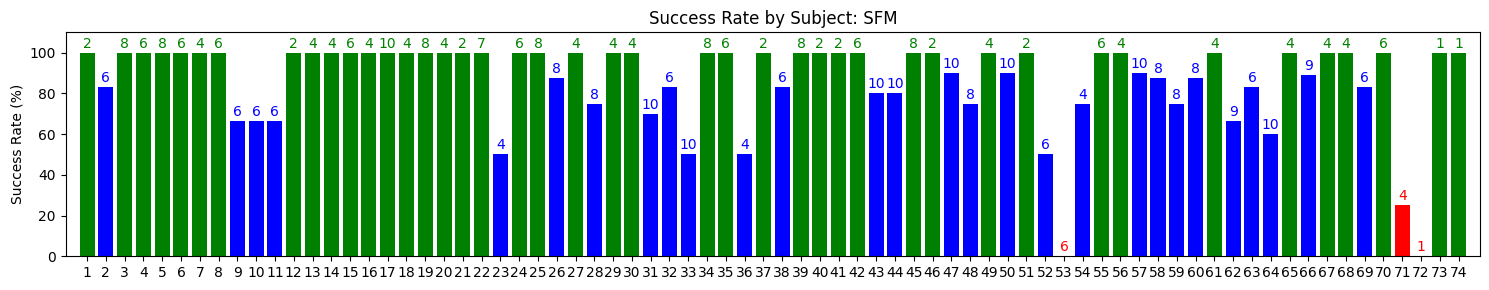

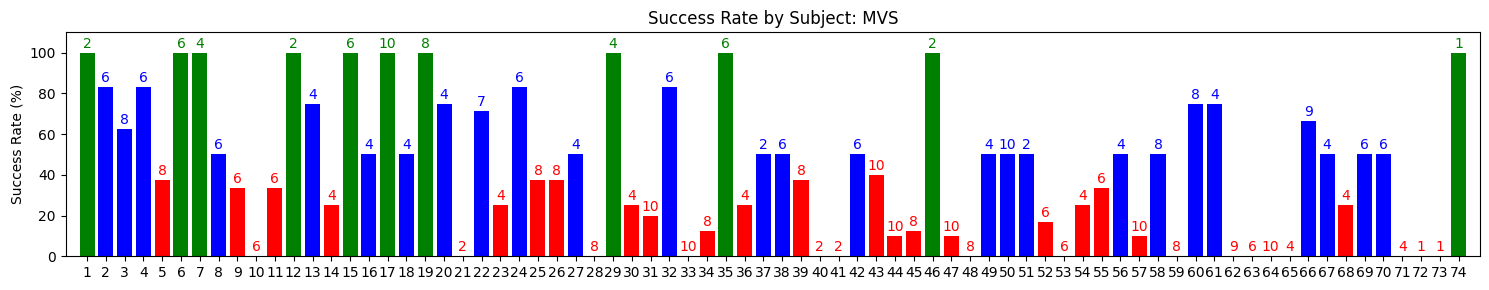

In [33]:
# Sample data: subjects, success rates, and total values

def plot_subject_success_rate(file, title):
    df_temp = df_results_save[df_results_save['File_Name'] == file]

    subjects = df_temp['Subject'].tolist()
    success_rates = df_temp['Success_rate'].tolist()
    total_values = df_temp['Total'].tolist()

    # Determine bar colors based on success rate
    colors = []
    for rate in success_rates:
        if rate == 100:
            colors.append('green')
        elif 50 <= rate < 100:
            colors.append('blue')
        else:
            colors.append('red')

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(15, 3))
    bars = ax.bar(subjects, success_rates, color=colors)

    # Annotate each bar with the total value
    for bar, total, color in zip(bars, total_values, colors):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{total}', ha='center', va='bottom', color=color)


    # Add labels and title
    ax.set_ylabel('Success Rate (%)')
    ax.set_title(f'Success Rate by Subject: {title}')
    ax.set_ylim(0, 110)
    
    plt.margins(x=0.01)


    # Show the plot
    plt.tight_layout()
    plt.show()
    
plot_subject_success_rate('cloud_and_poses.ply', 'SFM')
plot_subject_success_rate('scene_dense_mesh_refine.ply', 'MVS')

In [12]:
df_results_save

,Algorithm,SFM,File_Name,Subject,Image Data,Total,Fail,Success,Success_rate
0,MVG,MVG_MVS,cloud_and_poses.ply,1,"1D0L, 1D0R",2,0,2,100.000000
1,MVG,MVG_MVS,cloud_and_poses.ply,2,"2D4L, 2D5R, 2D5L, 2D0R, 2D4R, 2D0L",6,1,5,83.333333
2,MVG,MVG_MVS,cloud_and_poses.ply,3,"3D2R, 3D3L, 3D1R, 3D2L, 3D1L, 3D0L, 3D3R, 3D0R",8,0,8,100.000000
3,MVG,MVG_MVS,cloud_and_poses.ply,4,"4D2R, 4D0L, 4D1L, 4D1R, 4D0R, 4D2L",6,0,6,100.000000
4,MVG,MVG_MVS,cloud_and_poses.ply,5,"5D2L, 5D0R, 5D2R, 5D1L, 5D3R, 5D3L, 5D1R, 5D0L",8,0,8,100.000000
...,...,...,...,...,...,...,...,...,...
291,MVG_MVS,MVG_MVS,scene_dense_mesh.ply,70,"70D0R, 70D2R, 70D1L, 70D0L, 70D1R, 70D2L",6,3,3,50.000000
292,MVG_MVS,MVG_MVS,scene_dense_mesh.ply,71,"71D0R, 71D0L, 71D1R, 71D1L",4,4,0,0.000000
293,MVG_MVS,MVG_MVS,scene_dense_mesh.ply,72,72D0R,1,1,0,0.000000
294,MVG_MVS,MVG_MVS,scene_dense_mesh.ply,73,73D0R,1,1,0,0.000000


In [38]:
list_subject_best = [1, 4, 6, 7, 12, 15, 17, 19, 29, 35, 46, 74]
list_subject_best = [str(x) for x in list_subject_best]

df_filter = df_results[df_results['Subject'].isin(list_subject_best)].reset_index(drop=True)

for i, row in df_filter.iterrows():
    subject = row['Subject']
    data = row['Image Data']
    algorithm = row['Algorithm']
    volume = round(row['Volume'], 3)
    filename = row['File_Name']
    
    print(f'Subject {subject} - {data} - {algorithm} - {filename} - {volume}')

Subject 1 - 1D0L - MVG - cloud_and_poses.ply - 49.663
Subject 1 - 1D0R - MVG - cloud_and_poses.ply - 6.054
Subject 12 - 12D0L - MVG - cloud_and_poses.ply - 180.182
Subject 12 - 12D0R - MVG - cloud_and_poses.ply - 72.36
Subject 15 - 15D2L - MVG - cloud_and_poses.ply - 17.636
Subject 15 - 15D0L - MVG - cloud_and_poses.ply - 1481.621
Subject 15 - 15D1L - MVG - cloud_and_poses.ply - 16.599
Subject 15 - 15D2R - MVG - cloud_and_poses.ply - 2009.532
Subject 15 - 15D1R - MVG - cloud_and_poses.ply - 849.416
Subject 15 - 15D0R - MVG - cloud_and_poses.ply - 9.01
Subject 17 - 17D1L - MVG - cloud_and_poses.ply - 230.07
Subject 17 - 17D1R - MVG - cloud_and_poses.ply - 19.499
Subject 17 - 17D0L - MVG - cloud_and_poses.ply - 8.08
Subject 17 - 17D2R - MVG - cloud_and_poses.ply - 1.106
Subject 17 - 17D4R - MVG - cloud_and_poses.ply - 2226.049
Subject 17 - 17D3L - MVG - cloud_and_poses.ply - 22.869
Subject 17 - 17D3R - MVG - cloud_and_poses.ply - 7.491
Subject 17 - 17D2L - MVG - cloud_and_poses.ply - 76.

In [39]:
df_results

,Subject,Image Data,SFM,Algorithm,BG,Scale,Max Frames,Volume Calculation,File_Path,File_Name,Volume,Error
0,1,1D0L,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,49.662720,
1,1,1D0R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,6.053574,
2,10,10D2R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,3348.350963,
3,10,10D2L,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,0.000000,[Errno 2] No such file or directory: '/home/we...
4,10,10D0R,MVG_MVS,MVG,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,cloud_and_poses.ply,448.700003,
...,...,...,...,...,...,...,...,...,...,...,...,...
1707,9,9D1R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_texture.ply,134.319408,
1708,9,9D1R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_mesh_refine.ply,134.319721,
1709,9,9D3R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_mesh.ply,0.000000,[Errno 2] No such file or directory: '/home/we...
1710,9,9D3R,MVG_MVS,MVG_MVS,with_bg,100,5,PyntCloud,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,scene_dense_texture.ply,0.000000,[Errno 2] No such file or directory: '/home/we...


In [45]:
files_ply = [
    ('SFM', 'cloud_and_poses.ply'), 
    ('MVS_mesh', 'scene_dense_mesh.ply'),
    ('MVS_dense', 'scene_dense_texture.ply'),
    ('MVS_refine', 'scene_dense_mesh_refine.ply'),
    ]

df_to_save = []
for subject in [1, 4, 6, 7, 12, 15, 17, 19, 29, 35, 46, 74]:
# for subject in ['74']:
    subject = str(subject)
    df_results_subject = df_results[df_results['Subject'] == subject].reset_index(drop=True)
    
    list_file_name = list(set(df_results_subject['Image Data'].tolist()))
    list_file_name.sort()

    
    for file_name in list_file_name:
        df_results_subject_file = df_results_subject[df_results_subject['Image Data'] == file_name].reset_index(drop=True)
        
        to_save_list = []

        for mesh_type, ply in files_ply:
            volume = df_results_subject_file[df_results_subject_file['File_Name'] == ply].reset_index(drop=True)['Volume'][0]
            file_path = df_results_subject_file[df_results_subject_file['File_Name'] == ply].reset_index(drop=True)['File_Path'][0]
            
            df_to_save.append([subject, file_name, mesh_type, os.path.join(file_path, ply), volume])
            
columns = ['Subject', 'Image Data', 'Type', 'File_Path', 'Volume']
df_to_save = pd.DataFrame(df_to_save, columns=columns)

df_to_save.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_2_perfect_subjects.csv', index=False)

In [46]:
df_to_save

,Subject,Image Data,Type,File_Path,Volume
0,1,1D0L,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,49.662720
1,1,1D0L,MVS_mesh,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.397707
2,1,1D0L,MVS_dense,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.156429
3,1,1D0L,MVS_refine,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.157388
4,1,1D0R,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,6.053574
...,...,...,...,...,...
223,46,46D0R,MVS_refine,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,2.141923
224,74,74D0R,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,2268.287191
225,74,74D0R,MVS_mesh,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,155.341813
226,74,74D0R,MVS_dense,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,154.125191


In [47]:
files_ply = [
    ('SFM', 'cloud_and_poses.ply'), 
    ('MVS_mesh', 'scene_dense_mesh.ply'),
    ('MVS_dense', 'scene_dense_texture.ply'),
    ('MVS_refine', 'scene_dense_mesh_refine.ply'),
    ]

list_subject_testing = list(set(df_results['Subject'].tolist()))
list_subject_testing = [int(x) for x in list_subject_testing]
list_subject_testing.sort()
list_subject_testing = [str(x) for x in list_subject_testing]

df_to_save = []

for subject in list_subject_testing:
    subject = str(subject)
    df_results_subject = df_results[df_results['Subject'] == subject].reset_index(drop=True)
    
    list_file_name = list(set(df_results_subject['Image Data'].tolist()))
    list_file_name.sort()

    
    for file_name in list_file_name:
        df_results_subject_file = df_results_subject[df_results_subject['Image Data'] == file_name].reset_index(drop=True)
        
        to_save_list = []

        for mesh_type, ply in files_ply:
            volume = df_results_subject_file[df_results_subject_file['File_Name'] == ply].reset_index(drop=True)['Volume'][0]
            file_path = df_results_subject_file[df_results_subject_file['File_Name'] == ply].reset_index(drop=True)['File_Path'][0]
            
            df_to_save.append([subject, file_name, mesh_type, os.path.join(file_path, ply), volume])
            
columns = ['Subject', 'Image Data', 'Type', 'File_Path', 'Volume']
df_to_save = pd.DataFrame(df_to_save, columns=columns)
df_to_save = df_to_save[df_to_save['Volume'] != 0]

df_to_save.to_csv(f'/home/weiyanpeh/Git/SFM_Related/CADENCE/results_2_all_subjects.csv', index=False)
    

In [48]:
df_to_save

,Subject,Image Data,Type,File_Path,Volume
0,1,1D0L,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,49.662720
1,1,1D0L,MVS_mesh,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.397707
2,1,1D0L,MVS_dense,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.156429
3,1,1D0L,MVS_refine,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,71.157388
4,1,1D0R,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,6.053574
...,...,...,...,...,...
1704,73,73D0R,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,74.573463
1708,74,74D0R,SFM,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,2268.287191
1709,74,74D0R,MVS_mesh,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,155.341813
1710,74,74D0R,MVS_dense,/home/weiyanpeh/Git/SFM_Related/CADENCE/SHAPE_...,154.125191
